**Multi-resolution theory**: a form of signal processing and analysis concerned with the representation of signals (or images) at more than one resolution.

**Wavelets**: small waves of varying frequency and limited duration.

**Image pyramid**: A collection of decreasing resolution images arranged in the shape of a pyramid

Think of wavelets as one added layer of complexity to the Fourier transform. Remember, the Fourier transform encoded information in the frequency domain. But it's weakness is that it loses temporal information-- where objects are located in an image.

The wavelet transform recovered that information by combining both frequency information and temporal information in the same transform. The math is rather iffy, so we will mostly look at it from a broad overview. We will be using the package `pywt` to perform wavelet transforms.

In [3]:
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import pywt

First off, what is a wavelet? Remember that the Fourier transform is defined as taking the dot product with a sine function?

$$F(u) = \frac{1}{M} \sum^{M-1}_{x=0}{f(x) e^{-i 2 \pi u x / M}} $$

A wavelet is similar, but the function doesn't have the same amplitude at each point in time (or space). Instead, it decays. The wavelet basis function isn't limited to a single function either. Here are a few different basis functions for a wavelet transform:

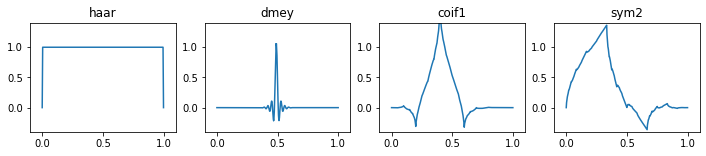

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(12,2))
types = ['haar', 'dmey', 'coif1', 'sym2']

for ax, typ in zip(axes, types):
    w = pywt.Wavelet(typ)
    (phi, psi, x) = w.wavefun()
    x = np.linspace(0, 1, len(phi))
    
    ax.plot(x, phi)
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.4, 1.4])
    ax.set_title(typ)

In [38]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [65]:
w = pywt.Wavelet('dmey')

print(w)

Before we try out the wavelet transform, we also have to introduce the idea of *multi-resolution analaysis*. Within an image, some features in an image are small, while others are large. Think of, for instance, a TEM image of some nanoparticles you just formulated. You may be interested in fine-resolution features, such as the texture of the nanoparticles; mid-resolution features, such as the size of the nanoparticles; and low-resolution features, such as clusters of nanoparticles. Each of these can be captured at a different resolution of the original image.

For example, take a look at this immunohistochemistry image that comes with `skimage`.

(-0.5, 511.5, 511.5, -0.5)

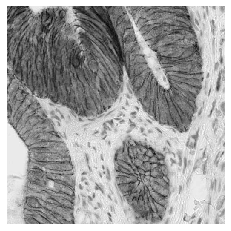

In [18]:
im = data.immunohistochemistry()
im = rgb2gray(im)

plt.imshow(im, cmap='gray')
plt.axis('off')

What different levels of information do you see?

We will perform a simple multi-resolution image analysis by resizing the image e.g. changing the number of pixels in the image by performing some kind of averaging technique. Not that the images in the right-hand column are the difference between the original image and the lower resolution image.

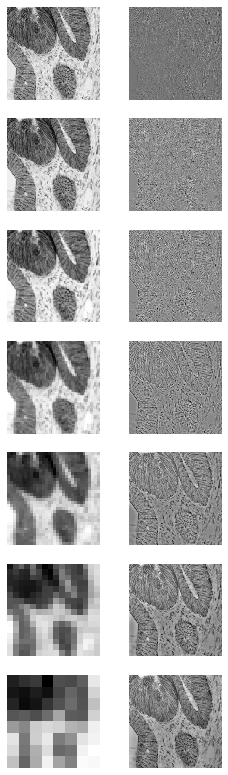

In [36]:
px = [512, 256, 128, 64, 32, 16, 8]
ims = {}
ips = {} # Predications based on upscaling back to original size
irs = {} # Residuals
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(4, 14))

for i, p in enumerate(px):
    ims[p] = resize(im, (p, p))
    ips[p] = resize(ims[p], (512,512))
    irs[p] = im - ips[p]
    
    axes[i, 0].imshow(ims[p], cmap='gray')
    axes[i, 1].imshow(irs[p], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')

You can see that each level of the *image pyramid* captures a different set of features. We were able to perform a multi-resolution image analysis without even introducing math as complicated as wavelets, but this is essentially what the wavelet transform does.

A wavelet with a high frequency is used to obtain an approximation of the original image.

This approximation of the original image is fed into a wavelet transform with a lower frequency to obtain an lower resolution approximation.

And so forth.

The neat thing about wavelet transforms that is different than the process we did above is that the original image can be recovered for the wavelet transform. Wavelet transforms are traditionally used to remove noise from images (high frequency information) and image compression (use a lower resolution image approximation).

Similar to the Fourier transform, it is perhaps easier to start with the 1D wavelet transform. Let's say we had a signal that was approximately a sine function with some noise introduced:

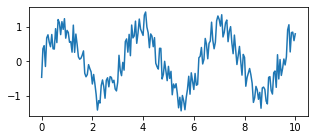

In [29]:
N = 201
x = np.linspace(0, 10, N)
y = np.sin(2*x) + np.random.random(size=N) - 0.5

fig, ax = plt.subplots(figsize=(5, 2))

ax.plot(x, y)

The wavelet transform outputs two objects: an approximation of the original signal at a lower resolution, and an array that contains information related to the detailed information at high frequencies within the original signal

In [46]:
cA, cD = pywt.dwt(y, 'db2')

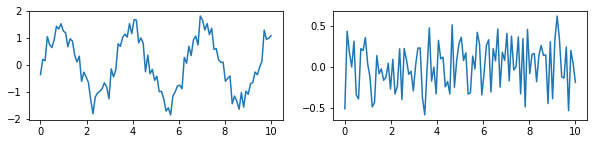

In [47]:
N2 = len(cA)
x2 = np.linspace(0, 10, N2)

fig, ax = plt.subplots(1, 2, figsize=(10, 2))
ax[0].plot(x2, cA)
ax[1].plot(x2, cD)


Similar to the multi-resolution analysis we performed previously, we can do the same with the wavelet transform:

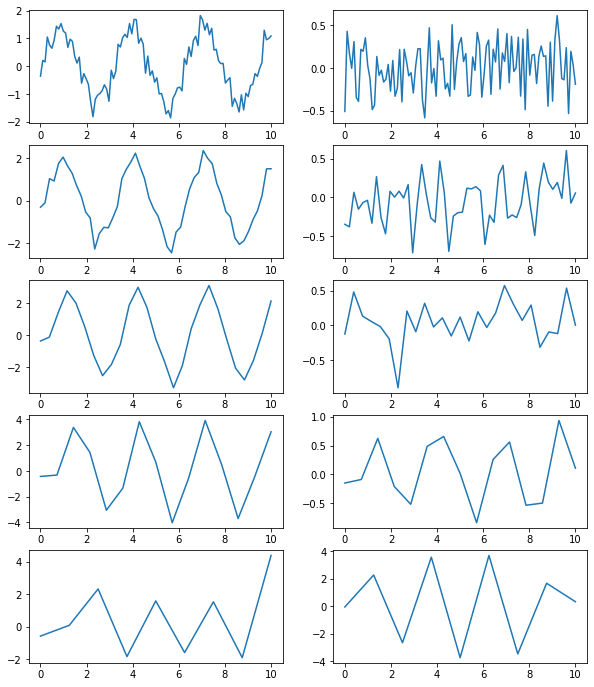

In [48]:
steps = [1, 2, 3, 4, 5]
N = {}
x = {}

fig, axes = plt.subplots(5, 2, figsize=(10, 12))
axes[0, 0].plot(x2, cA)
axes[0, 1].plot(x2, cD)


for i in range(1, 5):
    cA, cD = pywt.dwt(cA, 'db2')
    N[i] = len(cA)
    x[i] = np.linspace(0, 10, N[i])


    axes[i, 0].plot(x[i], cA)
    axes[i, 1].plot(x[i], cD)

The wavelet transform in 2D is conceptually the same as that for 1D, but the transform outputs four parts instead of two. A low-low component (a, the approximation), a low-high component (h, for horizontal details), a high-low component (v, for vertical details), and a high-high component (d, for diagonal details). Here's the first level wavelet transform for the immunohistochemistry image:

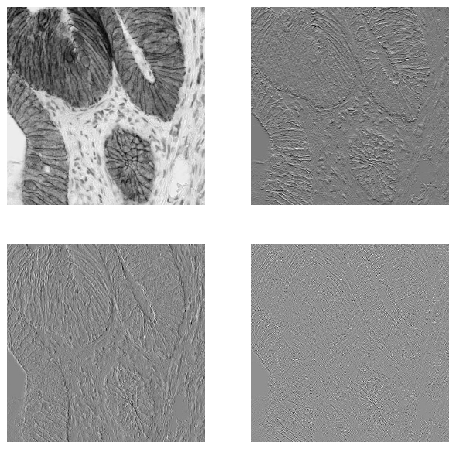

In [142]:
wp = pywt.WaveletPacket2D(data=im, wavelet='haar', mode='symmetric')
fig, axes = plt.subplots(2, 2, figsize=(8,8))
axes = [item for sublist in axes for item in sublist]

for ax, wi in zip(axes, ['a', 'h', 'v', 'd']):
    ax.imshow(wp[wi].data, cmap='gray')
    ax.axis('off')
# axes[0][0].imshow(wp['a'].data, cmap='gray')
# axes[0][0]

**In-class exercises**

* Perform a multi-resolution analysis on the immunohistochemistry image, similar to that done with the 1D sine wave.

* Using the documentation for `pywavelets`, see if you can recontruct the original immunohistochemistry image using the inverse wavelet transform.

* Notice that the information contained in the detailed components of the wavelet transform are all low intensity. How do you think you could use this fact to remove noise from the image, while still retaining the same resolution? How do you think you could use this to reduce the size of an image file while still keeping most of the information (image compression)? Try a few experiments with the data to see if you can do one of these two tasks.

* Do you think you could use the information contained in the wavelet transform to construct a few features for a feature dataset?